In [1]:
import pandas as pd
import numpy as np
import torch
import re
from sklearn import svm
from tqdm.notebook import tqdm
from sklearn.metrics import plot_confusion_matrix, f1_score
import pickle
from gensim.models import FastText
import copy
import matplotlib.pyplot as plt

In [2]:
def split_ipop(en_dataset, hi_dataset):
    data_X = copy.deepcopy(en_dataset['post_tokens'])
    data_X.extend(hi_dataset['post_tokens'])

    if not torch.is_tensor(en_dataset['class']):
        en_dataset['class'] = torch.tensor(en_dataset['class'])
    if not torch.is_tensor(hi_dataset['class']):
        hi_dataset['class'] = torch.tensor(hi_dataset['class'])

    data_Y = torch.concat(
        (en_dataset['class'] % 2, hi_dataset['class'] % 2)
    )
    return data_X, data_Y

def split_ipop_lang(dataset):
    data_X = dataset['post_tokens']
   
    if not torch.is_tensor(dataset['class']):
        data_Y = torch.tensor(dataset['class']) % 2
    else:
        data_Y = dataset['class'] % 2
    return data_X, data_Y

    

In [3]:
en_train = pickle.load(open('../data/en_train.p', 'rb'))
hi_train = pickle.load(open('../data/hi_train.p', 'rb'))
en_val = pickle.load(open('../data/en_validation.p', 'rb'))
hi_val = pickle.load(open('../data/hi_validation.p', 'rb'))
en_test = pickle.load(open('../data/en_test.p', 'rb'))
hi_test = pickle.load(open('../data/hi_test.p', 'rb'))


In [4]:

train_X, train_Y = split_ipop(en_train, hi_train)

en_val_X, en_val_Y = split_ipop_lang(en_val)
hi_val_X, hi_val_Y = split_ipop_lang(hi_val)

en_test_X, en_test_Y = split_ipop_lang(en_test)
hi_test_X, hi_test_Y = split_ipop_lang(hi_test)



In [5]:
# def preprocessor(sentence_list):
#     sentences = []
#     for sentence in sentence_list:
#         word_list = []
#         for word in sentence:
#             processed_word = re.sub('[^a-zA-Z]', "", word)
#             if processed_word != "":
#                 word_list.append(processed_word)
#         sentences.append(word_list)
#     return sentences

In [6]:
WV_SIZE = 100

In [7]:
model = FastText(vector_size=WV_SIZE, window=5, min_count=1)
model.build_vocab(corpus_iterable=train_X)
model.train(corpus_iterable=train_X, total_examples=len(train_X), epochs=10)

(5101589, 19435460)

In [8]:
def gen_vecs(sentences):
    vecs = []
    print(sentences[0])
    for sentence in tqdm(sentences):
        x = torch.zeros((1, WV_SIZE))
        for word in sentence:
            x += model.wv[word]
        vecs.append(x/len(sentence))
    vecs = torch.concat(vecs)
    return vecs
#2min30sec

In [9]:
train_vec_X = gen_vecs(train_X)

psa lgbt does not mean gay and lesbian the other two letters stand for things too 🤦 🏻 ‍ ♀️


  0%|          | 0/15383 [00:00<?, ?it/s]

In [10]:
en_val_X = gen_vecs(en_val_X)

rosé white girl of the month


  0%|          | 0/1548 [00:00<?, ?it/s]

In [11]:
hi_val_X = gen_vecs(hi_val_X)

<user> still many soul are alive in indian they will never allow to happen what happen to jews in 1 9 3 0 in germany we are with you


  0%|          | 0/385 [00:00<?, ?it/s]

In [12]:
en_test_X = gen_vecs(en_test_X)

his english periscope was awful apparently his chinese one was much better and had 1 6 m watching i do not speak gookanese though so be funny to see how this plays out with chink whales putting stops every <number>


  0%|          | 0/1562 [00:00<?, ?it/s]

In [13]:
hi_test_X = gen_vecs(hi_test_X)

there is no logical or just reason for a mediocre few shielded from competition propped up by inherited riches and passports to feast on the world riches under the guise of meritocracy <user> ungrateful refugee <number>


  0%|          | 0/385 [00:00<?, ?it/s]

In [14]:
train_vec_X.shape, train_Y.shape

(torch.Size([15383, 100]), torch.Size([15383]))

In [171]:
rbf_classifier = svm.SVC(kernel="rbf", gamma=10)
rbf_classifier.fit(train_vec_X,train_Y)

SVC(gamma=10)

In [172]:
en_val_X.shape, en_val_Y.shape

(torch.Size([1548, 100]), torch.Size([1548]))

c:\Users\dange\.conda\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


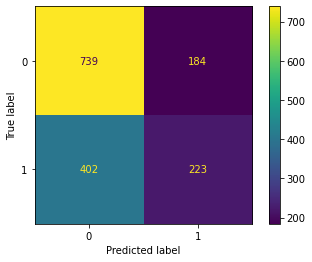

0.43217054263565896

In [173]:
prediction_en = rbf_classifier.predict(en_val_X)
plot_confusion_matrix(rbf_classifier, en_val_X, en_val_Y) 
plt.show()
f1_score(en_val_Y, prediction_en)

c:\Users\dange\.conda\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


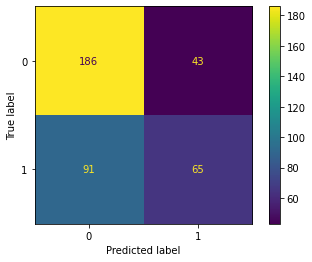

0.4924242424242424

In [174]:
prediction_hi = rbf_classifier.predict(hi_val_X)
plot_confusion_matrix(rbf_classifier, hi_val_X, hi_val_Y)
plt.show()
f1_score(hi_val_Y, prediction_hi)

In [15]:
en_f1 = []
hi_f1 = []
for i in range(1, 15):
    rbf_classifier = svm.SVC(kernel="rbf", gamma=i)
    rbf_classifier.fit(train_vec_X,train_Y)
    prediction_en = rbf_classifier.predict(en_val_X)
    en_f1.append(f1_score(en_val_Y, prediction_en))
    prediction_hi = rbf_classifier.predict(hi_val_X)
    hi_f1.append(f1_score(hi_val_Y, prediction_hi))

<AxesSubplot:xlabel='gamma', ylabel='value'>

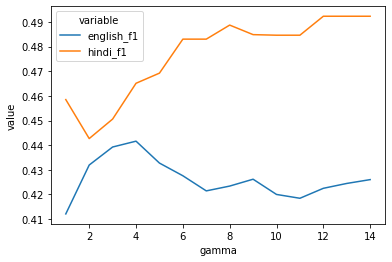

In [18]:
import seaborn as sns
data = pd.DataFrame({
    'gamma': np.arange(1,15),
    'english_f1': en_f1,
    'hindi_f1': hi_f1
})
sns.lineplot(data=pd.melt(data, ['gamma']), x='gamma', y='value', hue="variable")

In [19]:
test_pred_en = rbf_classifier.predict(en_test_X)
f1_score(en_test_Y, test_pred_en)

0.44557477110885046

In [ ]:
# poly_classifier = svm.SVC(kernel="poly", gamma=2)
# poly_classifier.fit(train_X,train_Y)

In [20]:
test_pred_hi = rbf_classifier.predict(hi_test_X)
f1_score(hi_test_Y, test_pred_hi)

0.4602510460251046

In [ ]:
# prediction = poly_classifier.predict(val_X)
# confusion_matrix(val_Y, prediction)
# f1_score(val_Y, prediction)

In [159]:
# lin_classifier = svm.SVC(kernel="linear", gamma=2)
# lin_classifier.fit(train_vec_X, train_Y)

SVC(gamma=2, kernel='linear')

c:\Users\dange\.conda\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


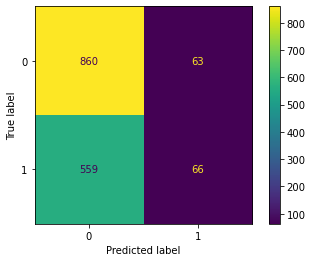

0.17506631299734746

In [160]:
# prediction_en = lin_classifier.predict(en_val_X)
# plot_confusion_matrix(lin_classifier, en_val_X, en_val_Y)
# plt.show()
# f1_score(en_val_Y, prediction_en)

c:\Users\dange\.conda\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


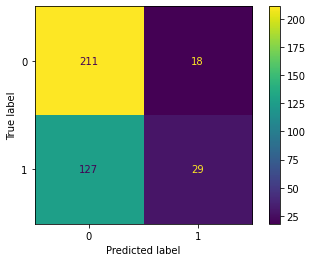

0.2857142857142857

In [162]:
# prediction_hi = lin_classifier.predict(hi_val_X)
# plot_confusion_matrix(lin_classifier, hi_val_X, hi_val_Y)
# plt.show()
# f1_score(hi_val_Y, prediction_hi)